In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('creditdata.csv')

In [ ]:
df.rename({'PAY_0':'PAY_1','default payment next month':'DEFAULT'},inplace=True,axis =1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
df['MARRIAGE'] = df['MARRIAGE'].map(lambda x: x if (x==1 or x==2) else 0 )
df['EDUCATION'] = df['EDUCATION'].map(lambda x: x if (x==1 or x==2 or x==3) else 0 )
df['PAY_1'] = df['PAY_1'].map(lambda x: x if x < 3 else 3 )
df['PAY_2'] = df['PAY_2'].map(lambda x: x if x < 3 else 3 )
df['PAY_3'] = df['PAY_3'].map(lambda x: x if x < 3 else 3 )
df['PAY_4'] = df['PAY_4'].map(lambda x: x if x < 3 else 3 )
df['PAY_5'] = df['PAY_5'].map(lambda x: x if x < 3 else 3 )
df['PAY_6'] = df['PAY_6'].map(lambda x: x if x < 3 else 3 )

In [ ]:
def PaymentBalance(row):
  if sum([row['BILL_AMT' + str(i)] for i in range(1,7)]) > 0:
    return sum([row['BILL_AMT' + str(i)]- row['PAY_AMT' + str(i)] for i in range(1,7)])/sum([row['BILL_AMT' + str(i)] for i in range(1,7)])
  else:
    return 0

def UsedBalance(row):
  if row['LIMIT_BAL'] > 0:
    return np.mean([row['BILL_AMT' + str(i)]- row['PAY_AMT' + str(i)] for i in range(1,7)])/row['LIMIT_BAL']
  else:
    return 0

def NegativeBal(row):
  return sum([1 for i in range(1,7) if row['BILL_AMT' + str(i)]<0])

def ZeroBal(row):
  return sum([1 for i in range(1,7) if row['BILL_AMT' + str(i)]==0])

def ZeroPay(row):
  return sum([1 for i in range(1,7) if row['PAY_AMT' + str(i)]==0])

df['USED_BAL']  = df.apply(lambda x: UsedBalance(x), axis =1)
df['PAY_BAL']   = df.apply(lambda x: PaymentBalance(x), axis =1)
df['NEG_BAL']   = df.apply(lambda x: NegativeBal(x), axis =1)
df['ZERO_BAL']  = df.apply(lambda x: ZeroBal(x), axis =1)
df['ZERO_PAY']  = df.apply(lambda x: ZeroPay(x), axis =1)

#Log Columns
df['LIMIT_BAL'] = np.log(df['LIMIT_BAL'] )

#Drop Bill and Pay Cols
drop_cols = ['BILL_AMT'+ str(i) for i in range(1,7)] +	['PAY_AMT'+ str(i) for i in range(1,7)]
df.drop(drop_cols,axis=1,inplace=True)

In [ ]:
categorical_cols = ['SEX','EDUCATION','MARRIAGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','NEG_BAL','ZERO_BAL','ZERO_PAY']
df = pd.get_dummies(data=df, columns = categorical_cols,drop_first=True)
df.head()

,ID,LIMIT_BAL,AGE,DEFAULT,USED_BAL,PAY_BAL,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,MARRIAGE_1,MARRIAGE_2,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,NEG_BAL_1,NEG_BAL_2,NEG_BAL_3,NEG_BAL_4,NEG_BAL_5,NEG_BAL_6,ZERO_BAL_1,ZERO_BAL_2,ZERO_BAL_3,ZERO_BAL_4,ZERO_BAL_5,ZERO_BAL_6,ZERO_PAY_1,ZERO_PAY_2,ZERO_PAY_3,ZERO_PAY_4,ZERO_PAY_5,ZERO_PAY_6
0,1,9.903488,24,1,0.058458,0.910566,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,2,11.695247,26,1,0.016774,0.707209,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,3,11.407565,34,0,0.167843,0.891612,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,10.819778,37,0,0.743153,0.963741,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,10.819778,57,0,0.167633,0.459946,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
cols = sorted(list(set(df.columns) - set(['DEFAULT','ID'])))

#X_train, X_test, y_train, y_test = train_test_split(df.drop(['default payment next month','ID'],axis=1),df['default payment next month'],test_size = 0.33)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,cols],df['DEFAULT'],test_size = 0.33,stratify=df['DEFAULT'])

In [ ]:
from sklearn.preprocessing import StandardScaler

Scale_columns = ['LIMIT_BAL',	'AGE'] + ['USED_BAL','PAY_BAL']

scaler  = StandardScaler()
X_train[Scale_columns] = scaler.fit_transform(X_train[Scale_columns])
X_test[Scale_columns]  = scaler.transform(X_test[Scale_columns])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

ip_shape = X_train.shape[1]
output_bias = (df['DEFAULT'].value_counts()[1])/df['DEFAULT'].count()
output_bias = tf.keras.initializers.Constant(output_bias)

model = keras.Sequential(
    [
        keras.Input(shape=(ip_shape)),
        layers.Dense(500, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1000, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1000, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(250, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation = 'sigmoid', bias_initializer=output_bias),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               28500     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 1000)              501000    
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              1001000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0         
                                                                 
 dense_3 (Dense)             (None, 250)               2

In [ ]:
import warnings
warnings.filterwarnings('ignore')

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(lr=0.0001),
    metrics=METRICS,
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=2048, verbose=1,validation_split=0.4,callbacks=[callback])

Epoch 1/100
6/6 [==============================] - 5s 632ms/step - loss: 0.7511 - accuracy: 0.4041 - auc: 0.5035 - val_loss: 0.6376 - val_accuracy: 0.7750 - val_auc: 0.3907
Epoch 2/100
6/6 [==============================] - 3s 546ms/step - loss: 0.5797 - accuracy: 0.7674 - auc: 0.4784 - val_loss: 0.5566 - val_accuracy: 0.7751 - val_auc: 0.4658
Epoch 3/100
6/6 [==============================] - 3s 539ms/step - loss: 0.5462 - accuracy: 0.7812 - auc: 0.4916 - val_loss: 0.5279 - val_accuracy: 0.7751 - val_auc: 0.6047
Epoch 4/100
6/6 [==============================] - 3s 541ms/step - loss: 0.5428 - accuracy: 0.7813 - auc: 0.5325 - val_loss: 0.5159 - val_accuracy: 0.7751 - val_auc: 0.6842
Epoch 5/100
6/6 [==============================] - 3s 541ms/step - loss: 0.5223 - accuracy: 0.7813 - auc: 0.5821 - val_loss: 0.5168 - val_accuracy: 0.7751 - val_auc: 0.7161
Epoch 6/100
6/6 [==============================] - 3s 539ms/step - loss: 0.5086 - accuracy: 0.7812 - auc: 0.6252 - val_loss: 0.5159 - v

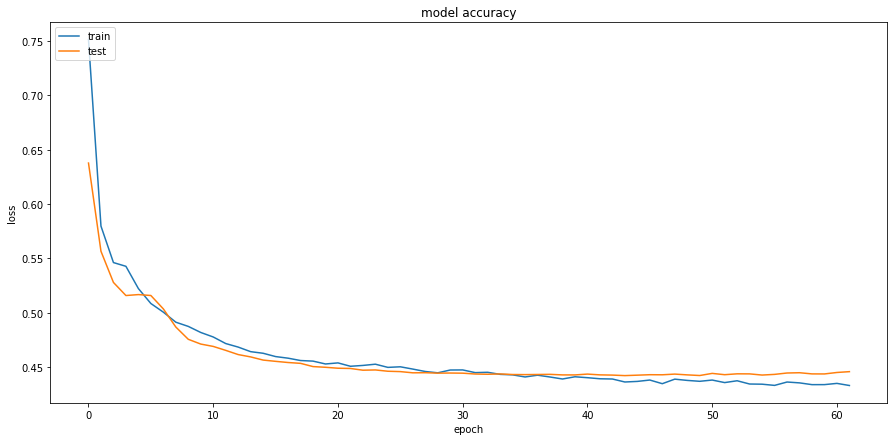

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
pred[:5]

array([[0.63502824],
       [0.0976288 ],
       [0.14092919],
       [0.21623385],
       [0.6361407 ]], dtype=float32)

In [ ]:
model.evaluate(X_train,y_train,batch_size=64)

315/315 [==============================] - 3s 9ms/step - loss: 0.4316 - accuracy: 0.8198 - auc: 0.7783


[0.4316076934337616, 0.8197512626647949, 0.7783291339874268]

In [ ]:
model.evaluate(X_test,y_test,batch_size=64)

In [ ]:
pip install alibi

     |████████████████████████████████| 390 kB 5.1 MB/s 
     |████████████████████████████████| 458.3 MB 11 kB/s 
     |████████████████████████████████| 3.1 MB 44.6 MB/s 
     |████████████████████████████████| 28.0 MB 1.6 MB/s 
     |████████████████████████████████| 5.6 MB 30.4 MB/s 
     |████████████████████████████████| 462 kB 34.3 MB/s 
     |████████████████████████████████| 1.3 MB 54.3 MB/s 
     |████████████████████████████████| 596 kB 58.5 MB/s 
     |████████████████████████████████| 59 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 48.9 MB/s 
     |████████████████████████████████| 3.3 MB 24.6 MB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052157 sha256=8dac0a5a4621e43a1c8354d90e92360f964f36ccae1ec2421bfba1ff4243b1f3
  Stored in directory: /root/.cache/pip/wheels/b6/09/83/36dd0224ce32dcdf5e218b36362235ca2e50cece60a966ae1b
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30692 sha

In [ ]:
from alibi.explainers import IntegratedGradients

ig  = IntegratedGradients(model,
                          layer=None,
                          method = "riemann_trapezoid",
                          n_steps=50,
                          internal_batch_size=100)

In [ ]:
explanation = ig.explain(np.array(X_test),
                         baselines=None,
                         target=y_test.values)

attributions = explanation.attributions

In [ ]:
len(attributions[0])

9900

In [ ]:
att = np.mean(attributions[0],axis=0)

In [ ]:
att.shape

(56,)

In [ ]:
temp = pd.DataFrame(att.reshape(-1,1),columns=['Importance'], index=cols).sort_values('Importance',ascending=False)

In [ ]:
temp

,Importance
PAY_1_0,0.072158
PAY_2_0,0.028340
MARRIAGE_2,0.026840
USED_BAL,0.024408
PAY_6_0,0.022720
LIMIT_BAL,0.018448
MARRIAGE_1,0.016944
SEX_2,0.013063
EDUCATION_1,0.009386
PAY_3_-1,0.008263


In [ ]:
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(10), list(temp.iloc[:10].values) , color='b', align='center')
plt.yticks(range(10), list(temp.index)[:10])
plt.xlabel('Relative Importance')

NameError: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
print("Test Score:", rf.score(X_test,y_test))
print("Train Score:", rf.score(X_train,y_train))

Test Score: 0.8134343434343434
Train Score: 0.9996517412935323


In [ ]:
pd.DataFrame(rf.feature_importances_.reshape(-1,1),columns=['Importance'], index=cols).sort_values('Importance',ascending=False)

,Importance
USED_BAL,0.155529
PAY_BAL,0.147298
AGE,0.129686
LIMIT_BAL,0.121975
PAY_1_2,0.057676
PAY_2_2,0.026716
SEX_2,0.023834
PAY_3_2,0.020798
PAY_4_2,0.019628
PAY_1_0,0.016361


In [ ]:
model.predict(X_test)